# SD701 Lab session: classification and clustering

The goal of this lab session is for you to get a good grasp of data cleaning, clustering, classification implementations and evaluations. For this reason, the lab is less focused on re-implementing existing algorithms, and more onto using what is already available and making sense of it.

Let us make our imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests
import time 
import queue
from sklearn import cluster
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, homogeneity_score, silhouette_score, calinski_harabasz_score
from scipy.stats import mode
from scipy.spatial import distance
from kmodes.kmodes import KModes


## The Palmer Penguin dataset

Let us look at the [Palmer penguins]() dataset. It is a small dataset that contains measurements about real-world penguins.

Our task is to:

   - Do an exploratory analysis of the data
   - Think about what algorithms and features we want to use, and how we need to transform our variables
   - Run our algorithms and evaluate them

In [2]:
#I had a SSL certificate problem reading directly from the link with pandas, this workaround seems to work although it's a bit circonvoluted

penguins_cs = pd.read_csv(StringIO(requests.get("https://tiphaineviard.com/files/SD701/labs/data/penguins_size.csv").content.decode("utf8")))

penguins_2 = pd.read_csv(StringIO(requests.get("https://tiphaineviard.com/files/SD701/labs/data/penguins_lter.csv").content.decode("utf8")))

### Exploratory analysis

In [3]:
penguins_cs.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
penguins_cs.columns

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

We clean the data before plotting.  
We standard scale our data :  
$$X' = \frac{X-E(X)}{\sigma(X)}$$
All of our variables are then on the same scale (approx. N(0,1)) which is way more effective to consistently compute distances. It is primordial to ensure KMeans and DBScan aren't biased by variables that are on different scales. It has no effect on some classifiers (RandomForest), and due to the same distance-bias, can improve other classification models.  
We use KNN to impute missing values. The intuition is that we impute based on n closest data points averaged on the missing axis. By default, n = 5. It has several advantages : it's not as arbitrary as simply filling with 0, it doesn't change the distribution as much as filling with a centrality indicator.

In [5]:
penguins_cs = penguins_cs[~penguins_cs["species"].isna()]
penguins_cs = penguins_cs.loc[penguins_cs.isna().sum(axis = 1) < len(penguins_cs.columns)/2, :]

le_species = LabelEncoder()
penguins_cs["species"] = le_species.fit_transform(penguins_cs["species"])

penguins_cat = penguins_cs[[col for col in penguins_cs.columns if col != "species"]].copy()

num_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
sc = StandardScaler()
penguins_cs[num_cols] = sc.fit_transform(penguins_cs[num_cols])

penguins_cs["sex"] = penguins_cs["sex"].replace(".", np.nan)
penguins_cs = pd.get_dummies(penguins_cs, drop_first=True) #we drop first to avoid colinearity

knn = KNNImputer()
penguins_cs = pd.DataFrame(knn.fit_transform(penguins_cs), columns=penguins_cs.columns)

penguins_num = penguins_cs[num_cols]

penguins_cs.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,0.0,-0.884499,0.785449,-1.418347,-0.564142,0.0,1.0,1.0
1,0.0,-0.811126,0.126188,-1.062250,-0.501703,0.0,1.0,0.0
2,0.0,-0.664380,0.430462,-0.421277,-1.188532,0.0,1.0,0.0
3,0.0,-1.324737,1.089724,-0.563715,-0.938776,0.0,1.0,0.0
4,0.0,-0.847812,1.748985,-0.777373,-0.689020,0.0,1.0,1.0


C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

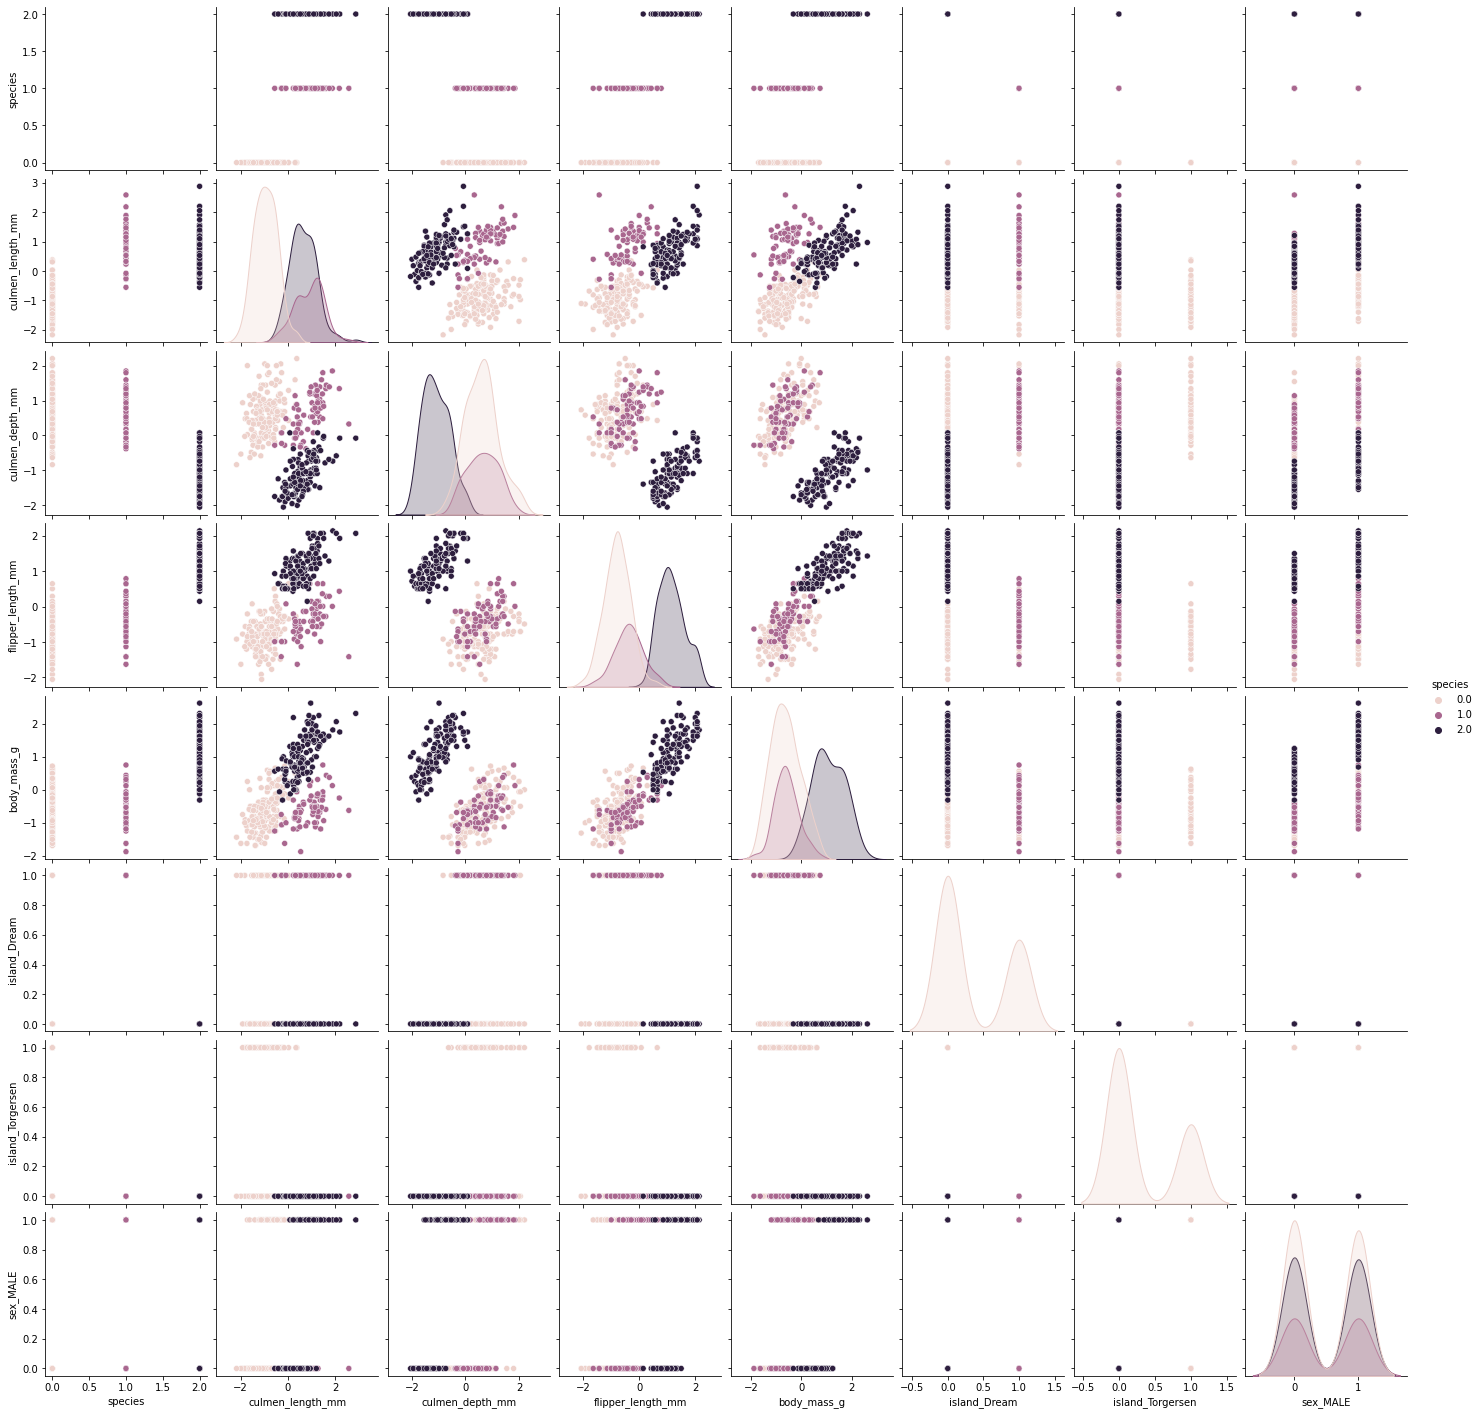

In [6]:
sns.pairplot(penguins_cs, vars = penguins_cs.columns, hue = "species")
plt.show()

The plots confirm that there are relations (mostly linear) between some columns. Moreover, they show us that we can intuitively see some natural separations between species based on multiple couples of features (or even single-features). Classification models should perform well on such data.  
Note we could have chosen Island as a classification target. Looking at the previous plot, the species variable explains almost all of the island variance (there is only a certain species on two of the three islands). Hence species seems a more interesting target.

### Learning on our dataset

#### Clustering

As you can see, this data is not readily adapted for clustering: many of the variables are non-numerical. We could try different strategies:

   - Getting rid of all non numerical variables
   - Converting categorical variables to a [one-hot vector](https://en.wikipedia.org/wiki/One-hot) to use them
   
We will try both approaches. Below is the code for the first approach, the second is yours to write. You can also update the first approach to fill n/a values with something better than $0$.

#### $k$-means

Let us focus on the $k$-means clustering algorithm. Once trained, the labels (_i.e._ the cluster assignation) is in `kmeans_algo.labels_`, and the centroids are in `kmeans_algo.cluster_centers_`.

With regards to clustering, we chose to use only numerical columns, as KMeans is distance-based, i.e. it performs poorly on OneHotEncoded axes.

In [7]:
n_clusters = 3
kmeans_algo = cluster.KMeans(n_clusters)
kmeans_algo.fit(penguins_num)

KMeans(n_clusters=3)

Plot the data with colours for each cluster (in two dimensions).

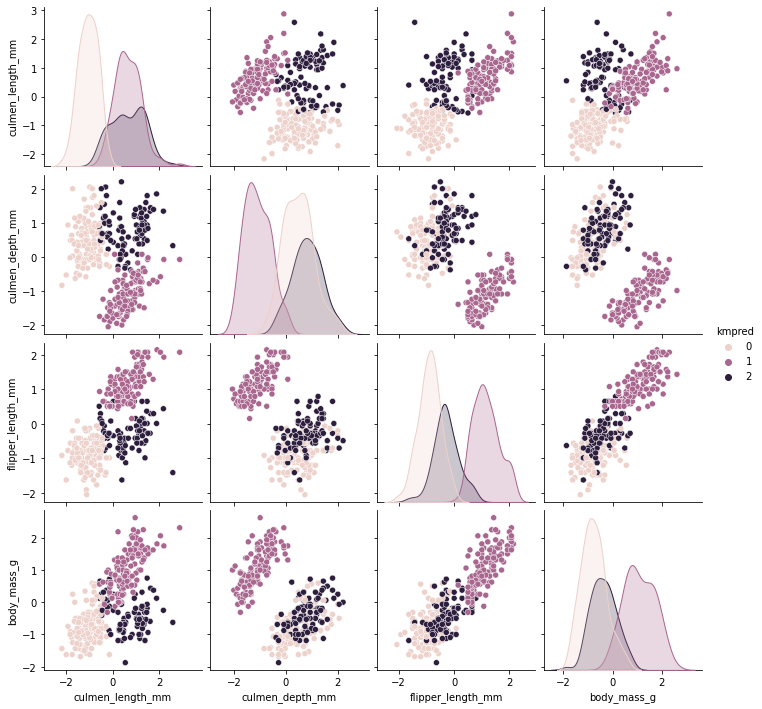

In [8]:
plot_km = penguins_num.copy()

plot_km["kmpred"] = kmeans_algo.labels_

sns.pairplot(plot_km, hue = "kmpred")
plt.show()

We notice this pairplot is almost identical to the previous pairplot with `hue="species"`. This will be confirmed by the upcoming classification analysis.  
We will now try to do something with categorical variables that we encoded previously.

In [9]:
n_clusters = 3
kmeans_wcat = cluster.KMeans(n_clusters)
kmeans_wcat.fit(penguins_cs[[col for col in penguins_cs.columns if col != "species"]])

KMeans(n_clusters=3)

C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\phile\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


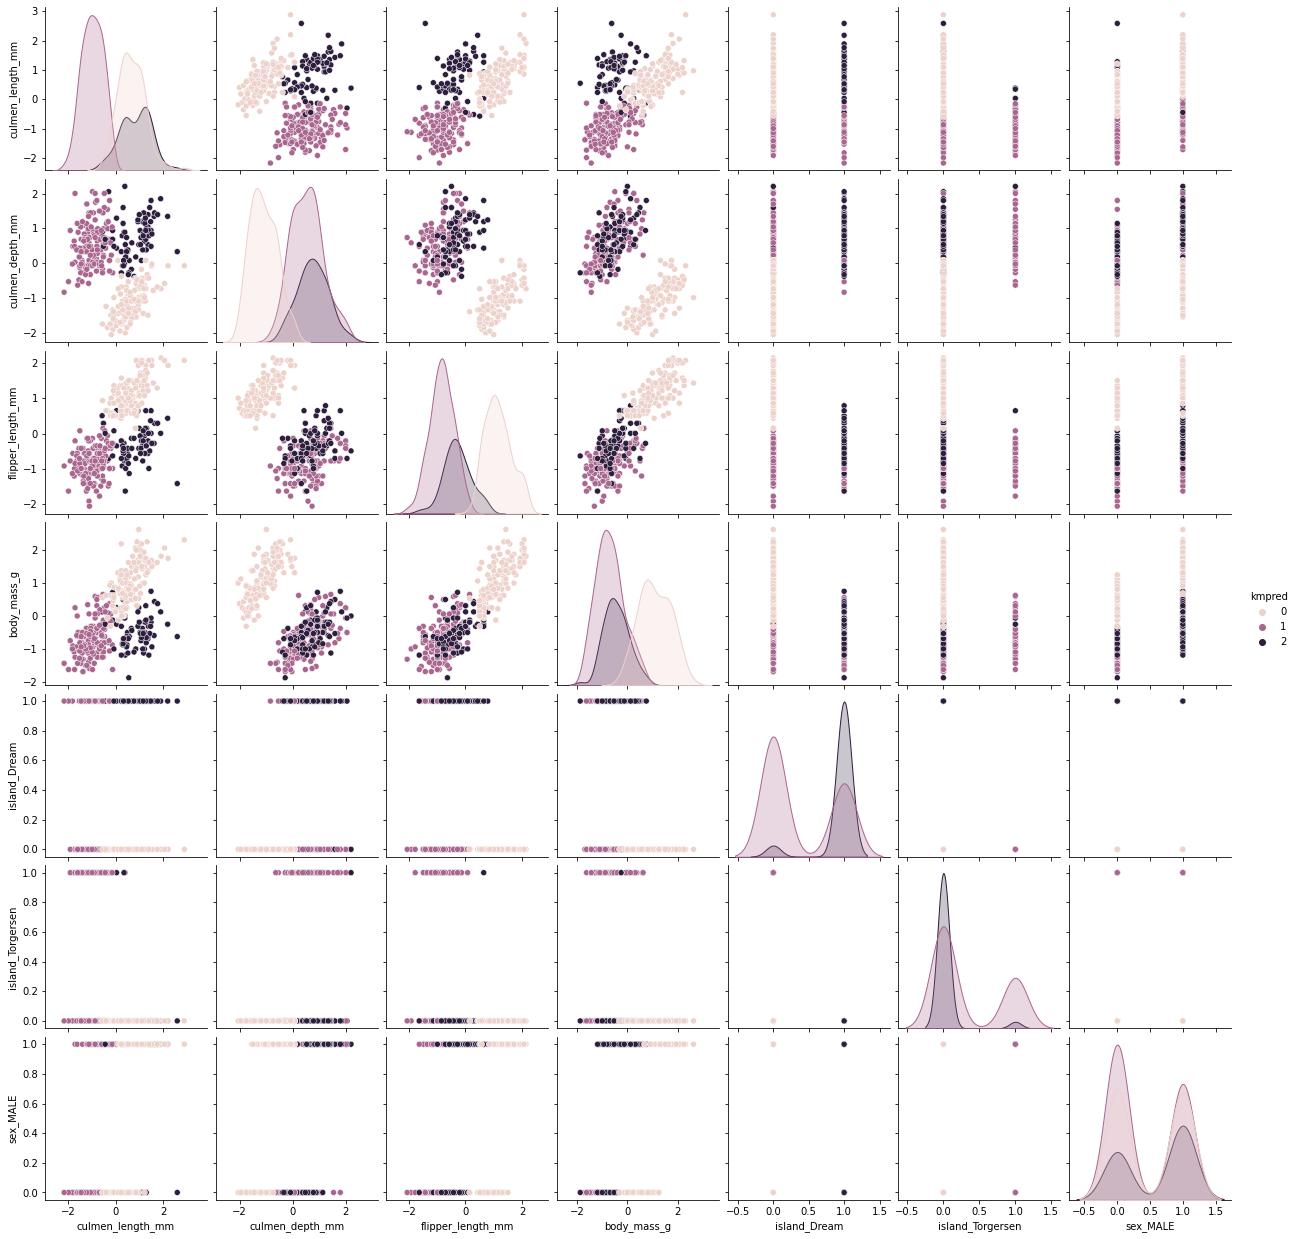

In [10]:
plot_km = penguins_cs[[col for col in penguins_cs.columns if col != "species"]].copy()

plot_km["kmpred"] = kmeans_wcat.labels_

sns.pairplot(plot_km, hue = "kmpred")
plt.show()

Before we compare the two KMeans methods' performance later, it should be noted that it is a bit weird to calculate the mean on discrete dimensions. What is the meaning of a kmeans algorithm with a centroid on axis `Island="Torgersen"` that is neither 0 or 1 ? How does one interpret such a model ?  
In order to have a meaningful clustering model on categorical data, we implement a variant of KMeans called KModes [(Huang, 1998)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf). We will also discretize non-categorical variables such that modes have more meaning and are more interpretable.

In [11]:
penguins_cat["sex"] = penguins_cat["sex"].replace(".", np.nan)

for col in ["sex","island"]:
    mask = penguins_cat[col].notnull()
    le = LabelEncoder()
    penguins_cat[col][mask] = le.fit_transform(penguins_cat[col][mask])

imputer = SimpleImputer(strategy="most_frequent")
penguins_cat = pd.DataFrame(imputer.fit_transform(penguins_cat), columns=penguins_cat.columns)
#KNNimputer uses mean which makes no sense because we only work on discrete data here
#I could've implemented KNN with mode myself from sklearn's source but I was too lazy here...

print(penguins_cat["sex"].unique(),penguins_cat["island"].unique())

for col in penguins_cat.columns:
    penguins_cat[col] = pd.cut(penguins_cat[col], 10, labels=list(range(10))) #cut rather than qcut else there is no mode !

penguins_cat.head()

[1 0] [2 0 1]


<ipython-input-11-d3efaa52a5f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_cat[col][mask] = le.fit_transform(penguins_cat[col][mask])


,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,9,2,6,1,2,9
1,9,2,5,2,3,0
2,9,2,5,3,1,0
3,9,1,7,3,2,0
4,9,2,8,3,2,9


In [12]:
n_clusters = 3
kmodes = KModes(n_clusters)
kmodes.fit(penguins_cat)

KModes(n_clusters=3)

As we've seen above, pairplots with categorical variables is hardly informative. We'll wait for evaluation to discuss the results of this model.

**Finding the right $k$ with the elbow method**

Let us find the most appropriate value for $k$ using the "elbow" method. It consists in plotting, for multiple values of $k$, the global clustering score. While in theory the score can be anything you want, for today let us use the _distortion_. For a cluster $C$ with centroid $c$ and points $(x^{c}_i)_{i=0}$, its distortion $d(c)$ is the sum of the squared distances between the points and the centroid:

$$
    d(c) = \sum_i |x_i - c|^2,
$$

and the distortion of our $k$ clusters is the sum of distortions for each cluster. You can fill the list `elbow_scores` with the scores you will have computed.

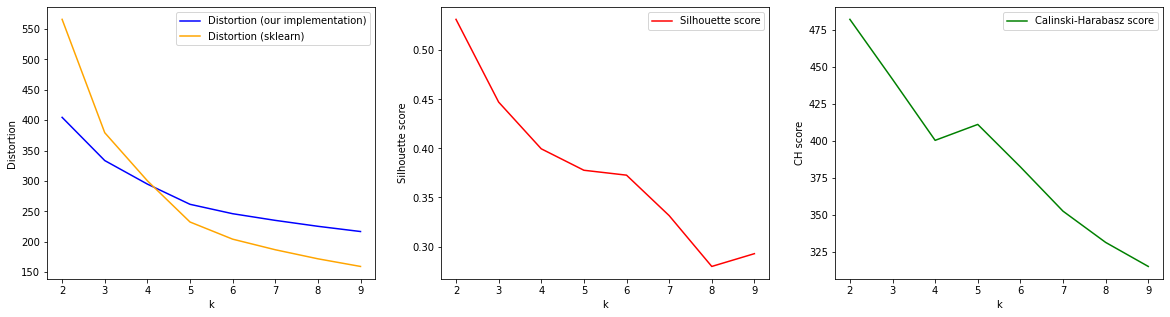

In [13]:
def distortion(data, clustering):
    # Write code here
    labels = clustering.labels_ 
    return np.sum([np.sum(distance.cdist(data[labels == i], [cc])) for i, cc in enumerate(clustering.cluster_centers_)])
    
    #Below is another method that yields the exact same results as the one above.
    #We implemented this because our distortion as written above was not the same as model.inertia_, which is strange.
    #Since both methods seem correct and yield the same results, we conclude that sklearn is wrong
    #(or rather, that their implementation must be ponderated, but the documentation does not state how the ponderation is done,
    #and we couldn't find any more info in the source code).

    #distortion = 0
    #for i, label in enumerate(labels):
    #    distortion += np.linalg.norm(data[i] - clustering.cluster_centers_[label])
    #return distortion

min_k = 2 #changed the value to 2 because 1 cluster is irrelevant
max_k = 10
elbow_scores = []
elbow_scores_2 = []
silhouette_scores = []
ch_scores = []

for i in range(min_k, max_k):
    model_ = cluster.KMeans(n_clusters=i)
    model_.fit(penguins_num)
    elbow_scores.append(distortion(penguins_num.values, model_)) #we compare our distortion and kmeans' (elbow_scores_2)
    elbow_scores_2.append(model_.inertia_)
    silhouette_scores.append(silhouette_score(penguins_num,model_.labels_)) #are clusters distant from one another ?
    ch_scores.append(calinski_harabasz_score(penguins_num,model_.labels_)) #a ratio between WCSS (== distortion == inertia) and BCSS (distance between cluster centers and overall mean)

fig, ax = plt.subplots(1,3,figsize = (20,5))
ax[0].plot(list(range(min_k, max_k)), elbow_scores,c="blue",label="Distortion (our implementation)")
ax[0].plot(list(range(min_k, max_k)), elbow_scores_2,c="orange",label="Distortion (sklearn)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Distortion")
ax[0].legend()
ax[1].plot(list(range(min_k, max_k)), silhouette_scores,c="red",label="Silhouette score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette score")
ax[1].legend()
ax[2].plot(list(range(min_k, max_k)), ch_scores,c="green",label="Calinski-Harabasz score")
ax[2].set_xlabel("k")
ax[2].set_ylabel("CH score")
ax[2].legend()
plt.show()

The elbow method shows us the choice of 3 to 5 clusters is best. We will stick with the first k = 3 model simply because it is the number of species in our data. This will allow us to compare KMeans and supervised models.  
On another note, the comparison between sklearn's inertia and our distortion shows us the curves are similar but ours is flatter somehow.

#### Classification

While we have not seen any classification algorithms in class yet, let us try to classify (instead of cluster) our data. The code for the classification algorithm is already completely written out for you, so you can focus on the other tasks.

Start by choosing what you want to classify on (for example, the species). You can use the exploratory data analysis you did before to guide your choice.

In [14]:
def train_test_split(data: pd.DataFrame, target_key:str, percent_test:int=15, stratify:bool=False, random_state:int=None):
    # Write code here
    data = data.sample(len(data), random_state=random_state).reset_index(drop=True) #shuffle in case data is sorted
    
    X = data[[col for col in data.columns if col != target_key]]
    y = data[target_key] #split X and y

    #X, y = X.values, y.values

    if stratify: #We implement stratify regarding y to answer the question in the md cell below
        index_split = [round(percent_test*len(y[y==mod])/100) for mod in np.unique(y)]
        X_train = pd.concat([X[y==mod][index_split[i]:] for i, mod in enumerate(np.unique(y))])
        X_test = pd.concat([X[y==mod][:index_split[i]] for i, mod in enumerate(np.unique(y))])
        y_train = pd.concat([y[y==mod][index_split[i]:] for i, mod in enumerate(np.unique(y))])
        y_test = pd.concat([y[y==mod][:index_split[i]] for i, mod in enumerate(np.unique(y))])
    else:
        index_split = round(percent_test*len(data)/100)
        X_train, X_test, y_train, y_test = X[index_split:], X[:index_split], y[index_split:], y[:index_split]
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = train_test_split(penguins_cs, target_key="species", random_state = 13, stratify = True)
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0.0    0.439863
2.0    0.360825
1.0    0.199313
Name: species, dtype: float64
0.0    0.450980
2.0    0.352941
1.0    0.196078
Name: species, dtype: float64


Check that your train and test set are appropriate. For example, is the repartition of the target variable similar? If not, how could you correct this issue?

Looking at the output above, we managed to get a similar target repartition between train and test. We'll see next that in this instance, data imbalance does not matter to our models. This is not always true.

In [15]:
# Simple random forest code
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

#adding two more models for fun
lr = LogisticRegression()
lr.fit(X_train, y_train)

svc = SVC()
svc.fit(X_train, y_train)

SVC()

## Evaluation

Now it is time to focus on the evaluation of our models. Let us use this as an opportunity to compare the clustering and classification approaches.

   - How can we evaluate the quality of the clustering? Think about the ranking agreement metrics we saw in the first lecture
   - Can we look at the confusion matrix outputted by our classification algorithm?
   - How can we evaluate the quality of the classification? You can go read again about the F1-score and ROC curves

Evaluating the linear model
ROC-AUC : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        23
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        18

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



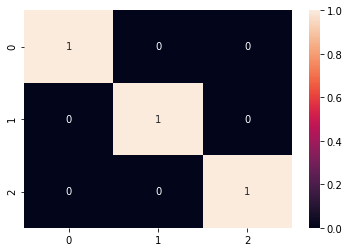

Evaluating Random Forest Classifier
ROC-AUC : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        23
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        18

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



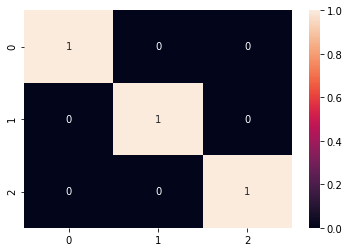

Evaluating Support Vector Classifier
ROC-AUC : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        23
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        18

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



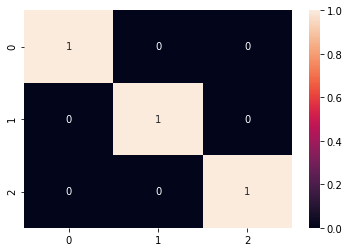

Evaluating KMeans
KMeans on Numerical columns
Homogeneity score: 0.798050614455528
ROC-AUC : 0.942293489922864
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90       151
         1.0       0.72      0.93      0.81        68
         2.0       1.00      1.00      1.00       123

    accuracy                           0.92       342
   macro avg       0.90      0.92      0.90       342
weighted avg       0.93      0.92      0.92       342



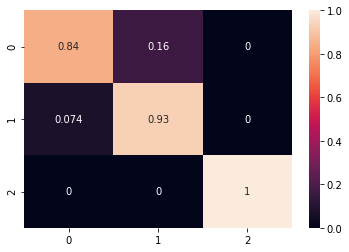

KMeans on Numerical columns + encoded Categorical columns
Homogeneity score: 0.8527985496262595
ROC-AUC : 0.9645498183739041
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       151
         1.0       0.85      0.93      0.89        68
         2.0       1.00      1.00      1.00       123

    accuracy                           0.95       342
   macro avg       0.94      0.95      0.94       342
weighted avg       0.96      0.95      0.95       342



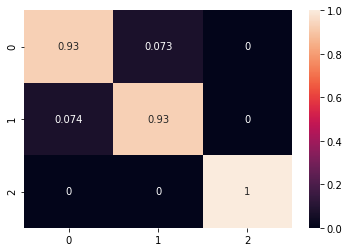

KModes
Homogeneity score: 0.1695468397142116
ROC-AUC : 0.6278112098588081
              precision    recall  f1-score   support

         0.0       0.53      0.99      0.69       151
         1.0       0.00      0.00      0.00        68
         2.0       0.95      0.48      0.64       123

    accuracy                           0.61       342
   macro avg       0.49      0.49      0.44       342
weighted avg       0.58      0.61      0.53       342



C:\Users\phile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


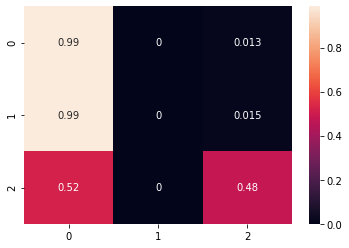

In [16]:
classes = penguins_cs["species"].unique()

print("Evaluating the linear model")

print("ROC-AUC :",roc_auc_score(label_binarize(y_test,classes = classes),label_binarize(lr.predict(X_test),classes = classes), multi_class="ovr"))
print(classification_report(y_test,lr.predict(X_test)))
sns.heatmap(confusion_matrix(y_test,lr.predict(X_test),normalize="true"), annot=True)
plt.show()

print("Evaluating Random Forest Classifier")

print("ROC-AUC :",roc_auc_score(label_binarize(y_test,classes = classes),label_binarize(rf.predict(X_test),classes = classes), multi_class="ovr"))
print(classification_report(y_test,rf.predict(X_test)))
sns.heatmap(confusion_matrix(y_test,rf.predict(X_test),normalize="true"), annot=True)
plt.show()

print("Evaluating Support Vector Classifier")

print("ROC-AUC :",roc_auc_score(label_binarize(y_test,classes = classes),label_binarize(svc.predict(X_test),classes = classes), multi_class="ovr"))
print(classification_report(y_test,svc.predict(X_test)))
sns.heatmap(confusion_matrix(y_test,svc.predict(X_test),normalize="true"), annot=True)
plt.show()

print("Evaluating KMeans")

print("KMeans on Numerical columns")
#assigning cluster prediction to species using mode

labels = np.zeros_like(kmeans_algo.labels_)
for i in range(len(np.unique(kmeans_algo.labels_))):
    mask = (kmeans_algo.labels_ == i)
    labels[mask] = mode(penguins_cs["species"][mask])[0]

print("Homogeneity score:",homogeneity_score(penguins_cs["species"],labels)) #this evaluates homogeneity of clusters given a y_true
print("ROC-AUC :",roc_auc_score(label_binarize(penguins_cs["species"],classes = classes),label_binarize(labels,classes = classes), multi_class="ovr"))
print(classification_report(penguins_cs["species"], labels))
sns.heatmap(confusion_matrix(penguins_cs["species"], labels, normalize="true"), annot=True)
plt.show()

print("KMeans on Numerical columns + encoded Categorical columns")

labels = np.zeros_like(kmeans_wcat.labels_)
for i in range(len(np.unique(kmeans_wcat.labels_))):
    mask = (kmeans_wcat.labels_ == i)
    labels[mask] = mode(penguins_cs["species"][mask])[0]

print("Homogeneity score:",homogeneity_score(penguins_cs["species"],labels)) #this evaluates homogeneity of clusters given a y_true
print("ROC-AUC :",roc_auc_score(label_binarize(penguins_cs["species"],classes = classes),label_binarize(labels,classes = classes), multi_class="ovr"))
print(classification_report(penguins_cs["species"], labels))
sns.heatmap(confusion_matrix(penguins_cs["species"], labels, normalize="true"), annot=True)
plt.show()

print("KModes")

labels = np.zeros_like(kmodes.labels_)
for i in range(len(np.unique(kmodes.labels_))):
    mask = (kmodes.labels_ == i)
    labels[mask] = mode(penguins_cs["species"][mask])[0]

print("Homogeneity score:",homogeneity_score(penguins_cs["species"],labels)) #this evaluates homogeneity of clusters given a y_true
print("ROC-AUC :",roc_auc_score(label_binarize(penguins_cs["species"],classes = classes),label_binarize(labels,classes = classes), multi_class="ovr"))
print(classification_report(penguins_cs["species"], labels))
sns.heatmap(confusion_matrix(penguins_cs["species"], labels, normalize="true"), annot=True)
plt.show()

KMeans is almost as performant at discriminating between the three classes as an actual classifier ! This is reassuring : the separation exists within the very structure of the data, and isn't only a property of human labeling.  
Adding categorical variables improves KMeans' performance -- but we should not forget it is not KMean's purpose to classify properly, and discrete dimensions negatively impact the interpretability of centroids.  
KModes performs very poorly. Maybe it could be improved, but for now I lack further ideas.

## Implementing DBScan

For the last part of the lab, let us focus a little bit on implementation. Your goal is to reimplement a functional version of the [DBScan algorithm]() that we saw during the lecture. You will find below a skeleton of code that you can fill in.

Once you have a functional version (if you still have time), you can try to make your implementation faster, by thinking about the following questions:

   - Can the neighbourhood lookup be faster?
   - Can the $\mu$ parameter be implemented easily?
   - How can the scalability of the algorithm be tested?

In [17]:
def dbscan(data: pd.DataFrame, epsilon: float, mu:int =1):
    neighbors = np.array([(distance.cdist([point_], data) <= epsilon).nonzero()[1] for point_ in data]) #compute list of neighbors for all observations
    ecp = (np.array(list(map(len, neighbors)))>=mu).nonzero()[0] #compute list of core points
    encp = (np.array(list(map(len, neighbors)))<mu).nonzero()[0] #list of non-core points
    eedge = [x for x in encp if np.any(np.isin(neighbors[x], ecp))] #list of edge points, ie non-core points that are in the neighborhood of a core point
    point_label = np.zeros(len(data)) #create labels (all data is noise at the start)
    cl = 1 #initialize cluster variable
    for i in range(len(data)): #for each point
        ecp_cl, ecp_seen = list(), list() #we will use this later to "propagate" the cluster
        if i in ecp: #if i is a core point
            point_label[i] = cl #assign it to current cluster
            for x in neighbors[i]: #for each point in its neighborhood
                if x not in ecp_cl and x not in ecp_seen: #check point isn't already in the "to do later list"
                    if x in ecp: #if that is also a core point
                        ecp_cl.append(x) #add it to the "to do later list"
                        point_label[x] = cl #assign it to current cluster
                    elif x in eedge: #if it's an edge point
                        point_label[x] = cl #assign it to current cluster
                        #note we don't need to add it to the "to do later list" because edge points do not propagate clusters, only core points do
            while len(ecp_cl)>0: #for each point in the "to do later list"
                y = ecp_cl[-1]
                for x in neighbors[y]: #this is the same loop as above
                    if x not in ecp_cl and x not in ecp_seen:
                        if x in ecp:
                            ecp_cl.append(x)
                            point_label[x] = cl
                        elif x in eedge:
                            point_label[x] = cl     
                ecp_cl.remove(y), ecp_seen.append(y)
        cl += 1 #create a new cluster once all loops above are done (ie all points the previous cluster could be propagated to have been reached)
        #note that cl will be incremented even if no point was assigned to a cluster this iteration
        #this means that we could have point_label.unique() == [1, 36, 242]
        #this is why we LabelEncode below
    return point_label #return labels for all data points

In [18]:
def dbscan2(data: pd.DataFrame, epsilon: float, mu:int =1): #from wikipedia pseudocode
    C = 0
    point_label = np.array(["undefined" for _ in range(len(data))])
    for i in range(len(data)):
        if isinstance(point_label[i],str):
            neighbors = ((distance.cdist([data[i]], data) <= epsilon).nonzero()[1]).tolist()
            if len(neighbors)<mu:
                point_label[i]=-1
            else:
                C += 1
                point_label[i]=C
                neighbors.remove(i)
                S = neighbors
                y=0
                while y < len(S):
                    if point_label[S[y]]==-1:
                        point_label[S[y]]=C
                    if isinstance(point_label[S[y]],str):
                        point_label[S[y]]=C
                        neighbors = (distance.cdist([data[S[y]]], data) <= epsilon).nonzero()[1]
                        if len(neighbors)>=mu:
                            [S.append(n) for n in neighbors if n not in S]
                    y+=1
    return point_label

<ipython-input-17-3e8dcb8459fb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  neighbors = np.array([(distance.cdist([point_], data) <= epsilon).nonzero()[1] for point_ in data]) #compute list of neighbors for all observations


[0 1 2 3]
[0 1 2 3]


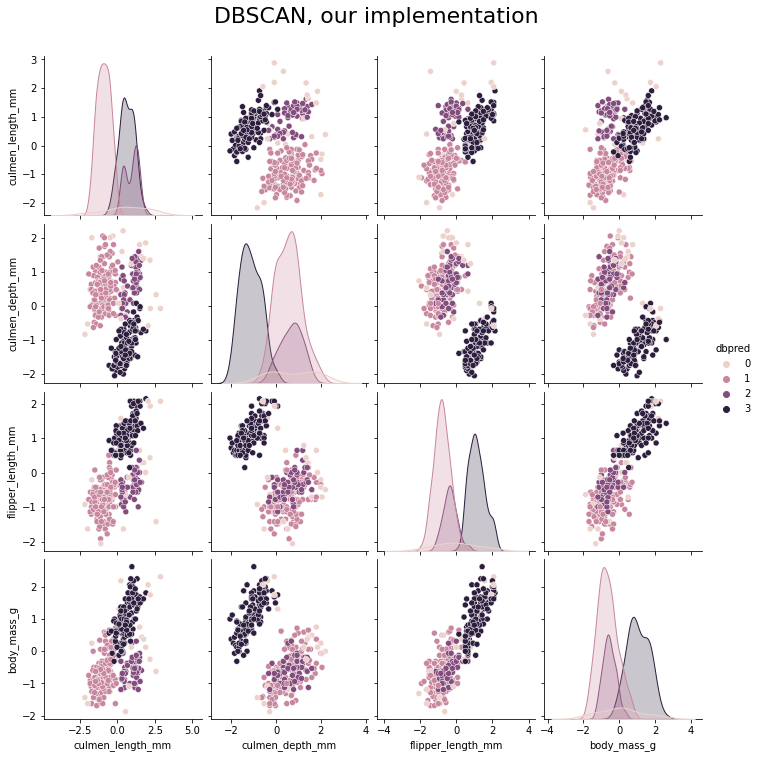

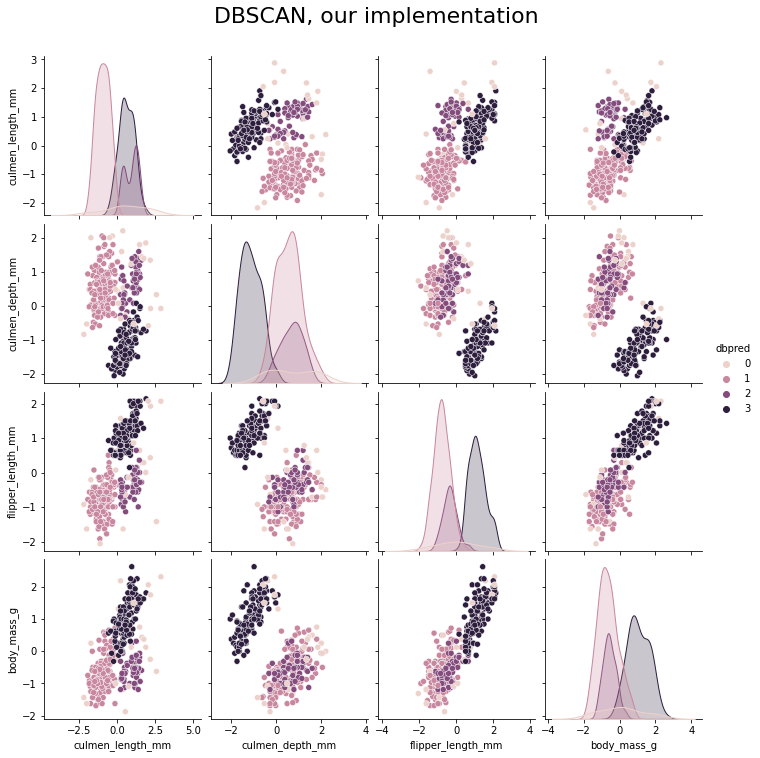

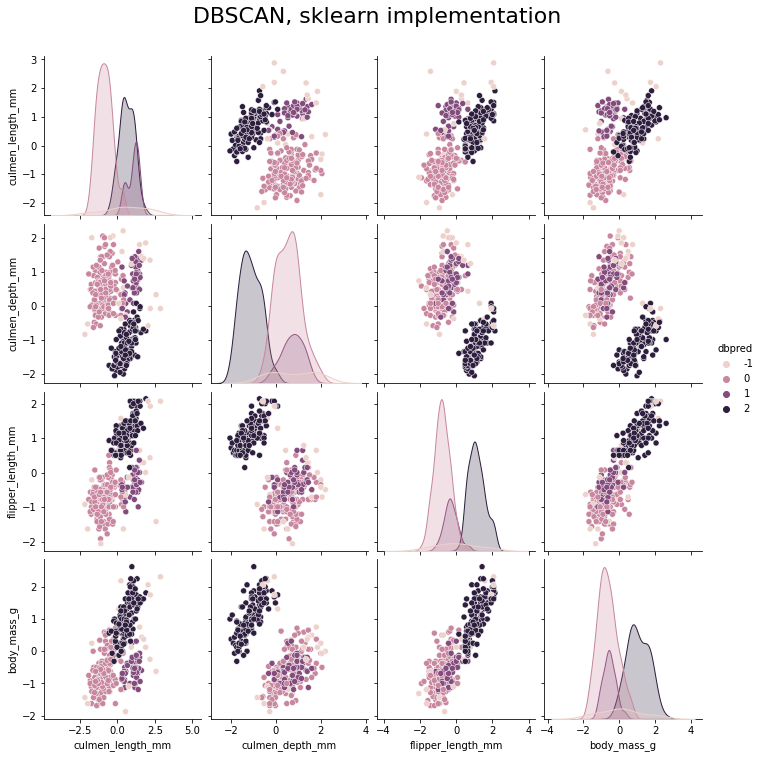

In [19]:
T0 = time.time()
point_label = dbscan(penguins_num.values,.8,20)
our_implem_time = time.time()-T0

T0 = time.time()
point_label_wiki = dbscan2(penguins_num.values,.8,20)
wiki_time = time.time()-T0

T0 = time.time()
point_label_sklearn = cluster.DBSCAN(.8,min_samples=20).fit_predict(penguins_num.values)
sklearn_time = time.time()-T0

le = LabelEncoder() #labelencode because of our DBScan implementation
point_label_e = le.fit_transform(point_label)
print(np.unique(point_label_e))

le = LabelEncoder() #labelencode because of our DBScan implementation
point_label_wiki = le.fit_transform(point_label_wiki)
print(np.unique(point_label_wiki))

plot_dbscan = penguins_num.copy()
plot_wiki = penguins_num.copy()
plot_skscan = penguins_num.copy()

plot_dbscan["dbpred"] = point_label_e
plot_wiki["dbpred"] = point_label_wiki
plot_skscan["dbpred"] = point_label_sklearn

g=sns.pairplot(plot_dbscan, hue = "dbpred")
g.fig.suptitle("DBSCAN, our implementation", fontsize=22, y = 1.05)
plt.show()
g=sns.pairplot(plot_wiki, hue = "dbpred")
g.fig.suptitle("DBSCAN, our implementation", fontsize=22, y = 1.05)
plt.show()
g=sns.pairplot(plot_skscan, hue = "dbpred")
g.fig.suptitle("DBSCAN, sklearn implementation", fontsize=22, y = 1.05)
plt.show()

Evaluating DBScan
Homogeneity score : 0.9090476408256124
ROC-AUC : 0.9752620679466236
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       142
         1.0       0.98      0.90      0.94        58
         2.0       1.00      1.00      1.00       118

    accuracy                           0.98       318
   macro avg       0.98      0.96      0.97       318
weighted avg       0.98      0.98      0.98       318



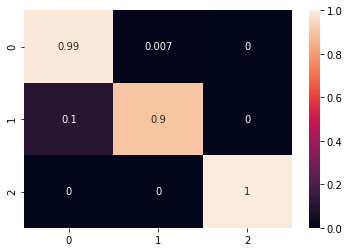

Actual accuracy : 0.9093567251461988
Time : 1.022s
Evaluating DBScan by wikipedia
Homogeneity score : 0.9183255154525124
ROC-AUC : 0.9787736353647244
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       142
         1.0       0.98      0.91      0.95        57
         2.0       1.00      1.00      1.00       117

    accuracy                           0.98       316
   macro avg       0.98      0.97      0.97       316
weighted avg       0.98      0.98      0.98       316



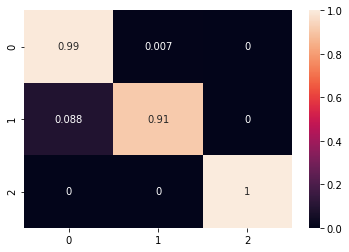

Actual accuracy : 0.9064327485380117
Time : 2.856s
Evaluating Sklearn's implementation
Homogeneity score : 0.8647343003743007
ROC-AUC : 0.9503330721003135
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       142
         1.0       1.00      0.78      0.87        58
         2.0       1.00      1.00      1.00       118

    accuracy                           0.96       318
   macro avg       0.97      0.93      0.94       318
weighted avg       0.96      0.96      0.96       318



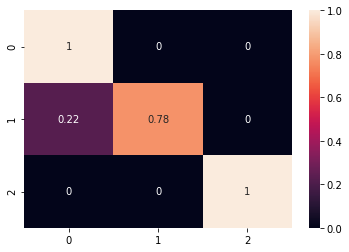

Actual accuracy : 0.8918128654970761
Time : 0.003s


In [20]:
print("Evaluating DBScan")

#assigning cluster prediction to species using previous plot

denoised = point_label_e[point_label_e != 0] - 1 #ignoring points classified as noise

y_true = penguins_cs["species"][point_label_e != 0]

labels = np.zeros_like(denoised)
for i in range(len(np.unique(denoised))):
    mask = (denoised == i)
    labels[mask] = mode(y_true[mask])[0]

print("Homogeneity score :",homogeneity_score(y_true,labels))
print("ROC-AUC :",roc_auc_score(label_binarize(y_true,classes=classes),label_binarize(labels,classes=classes), multi_class="ovr"))
print(classification_report(y_true, labels))
sns.heatmap(confusion_matrix(y_true, labels, normalize="true"), annot=True)
plt.show()

print("Actual accuracy :", sum(labels==y_true)/len(point_label_e)) #accuracy without ignoring noisy points == noisy points are always misclassified

print(f"Time : {round(our_implem_time,3)}s")

print("Evaluating DBScan by wikipedia")

#assigning cluster prediction to species using previous plot

denoised = point_label_wiki[point_label_wiki != 0] - 1 #ignoring points classified as noise

y_true = penguins_cs["species"][point_label_wiki != 0]

labels = np.zeros_like(denoised)
for i in range(len(np.unique(denoised))):
    mask = (denoised == i)
    labels[mask] = mode(y_true[mask])[0]

print("Homogeneity score :",homogeneity_score(y_true,labels))
print("ROC-AUC :",roc_auc_score(label_binarize(y_true,classes=classes),label_binarize(labels,classes=classes), multi_class="ovr"))
print(classification_report(y_true, labels))
sns.heatmap(confusion_matrix(y_true, labels, normalize="true"), annot=True)
plt.show()

print("Actual accuracy :", sum(labels==y_true)/len(point_label_e)) #accuracy without ignoring noisy points == noisy points are always misclassified

print(f"Time : {round(wiki_time,3)}s")

print("Evaluating Sklearn's implementation")

#assigning cluster prediction to species using previous plot

denoised = point_label_sklearn[point_label_sklearn != -1] #ignoring points classified as noise

y_true = penguins_cs["species"][point_label_sklearn != -1]

labels = np.zeros_like(denoised)
for i in range(len(np.unique(denoised))):
    mask = (denoised == i)
    labels[mask] = mode(y_true[mask])[0]

print("Homogeneity score :",homogeneity_score(y_true,labels))
print("ROC-AUC :",roc_auc_score(label_binarize(y_true,classes=classes),label_binarize(labels,classes=classes), multi_class="ovr"))
print(classification_report(y_true, labels))
sns.heatmap(confusion_matrix(y_true, labels, normalize="true"), annot=True)
plt.show()

print("Actual accuracy :", sum(labels==y_true)/len(point_label_e)) #accuracy without ignoring noisy points == noisy points are always misclassified

print(f"Time : {round(sklearn_time, 3)}s")

We excluded categorical columns yet again because discrete values behave differently when it comes to distance computation.  
Our implementation and wikipedia's are slower but classify better in this instance. Wikipedia's is apparently the best on this data. Sklearn's implementation is by far the fastest.  
We obtain good results because this dataset is very clean and there are clear separations between clusters/classes. We also excluded the noise from our classification metrics, but they are straight misclassifications. Taking noise into account, accuracy is lower than KMeans' (see "actual accuracy"). It should be noted that it took several trials to find good values for epsilon and mu.  
Comparing DBScan and KMeans on this dataset, DBScan is better at classification on non-noise observations, but KMeans is easier to use (no need to test for many epsilon-mu couples before a good solution is found, no observations are classified as noise) and has overall better accuracy. It should also generalize better : DBScan is Density-Based (duh!), and changing the number of observations changes the density, so it requires constant hyperparameter-tuning.  
Regarding scalability, we could generate new data points and test the speed of the different implementations using smart (noisy) methods. We could also theoretically calculate the speed. It would be in the worst case (computing distances between all points a priori like we do in the first implementation, or because all points are distant from one another in the wikipedia implementation): $$O(N^2)$$